## SI Figure of wind, solar, demand by year

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import pickle
from collections import OrderedDict

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 600
#mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
pdf = False
years = range(1979, 2021)

norm = {
    'ERCOT' : 26308, # Mean demand (MW) for file ERCOT_demand_synthetic_1950-2020_MEM.csv
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}

dfs = {
    'demand' : pd.read_csv('../../Input_Data/n_years2/CONUS_demand_synthetic_1950-2020_MEM_deltaT4.csv', header=1),
    'wind' : pd.read_csv('../../Input_Data/n_years2/20210921_US_mthd3_1950-2020_wind_deltaT4.csv', header=1),
    'solar' : pd.read_csv('../../Input_Data/n_years2/20210921_US_mthd3_1950-2020_solar_deltaT4.csv', header=1),
}

vals = {
    'demand' : 'demand (MW)',
    'wind' : 'w_cfs',
    'solar' : 's_cfs',
}

cnt = 0
for series, val in vals.items():
    mean = []
    for year in years:
        df = dfs[series]
        tmp = df[ df['year'] == year ]
        mean.append( np.mean(tmp[val]) )
    if cnt == 0:
        DF = pd.DataFrame({'year' : years, series : mean})
    else:
        DF[series] = mean
    cnt += 1
print(DF.head())

   year         demand      wind     solar
0  1979  301977.505594  0.283799  0.267455
1  1980  309578.189208  0.274009  0.263952
2  1981  302284.447717  0.270182  0.259125
3  1982  299633.260502  0.279728  0.256691
4  1983  305800.809361  0.267576  0.254585


demand, mean: 303.8949, std: 3.9349, rel std: 0.0129
wind, mean: 0.2854, std: 0.0137, rel std: 0.0482
solar, mean: 0.2646, std: 0.0040, rel std: 0.0149
Saving: plots/si_resources_by_year_CONUS2.png


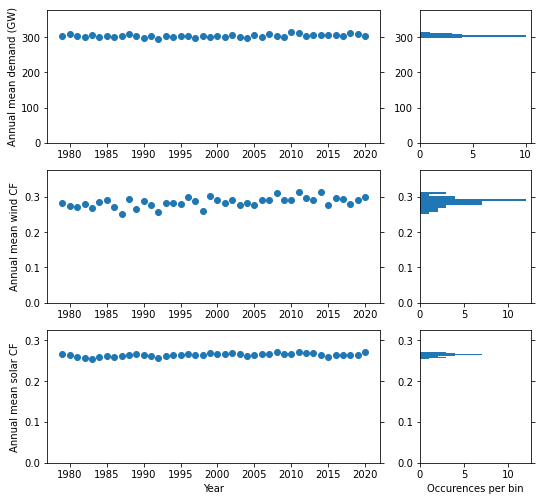

In [3]:
M = {
    'opt' : '10 high-resource years',
    'test' : '10 low-resource years',
    'other' : 'Other years'
}
LAB = {
    'demand' : ['Annual mean demand (GW)', 250, 350],
    'wind' : ['Annual mean wind CF', .2, .35],
    'solar' : ['Annual mean solar CF', .22, .3],
}

def plot_resources_for_region(region, df, save_name):

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7.6, 7), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('white')

    i = 0
    for col in df.columns:
        if col == 'year':
            continue
        
        denom = 1 if col != 'demand' else 1000
        axs[i][0].scatter(df['year'], df[col]/denom, marker='o', linestyle='-')
        axs[i][1].hist(df[col]/denom, orientation='horizontal')
        mean = np.mean( df[col]/denom )
        std = np.std( df[col]/denom )
        rel = std/mean
        print(f"{col}, mean: {mean:.4f}, std: {std:.4f}, rel std: {rel:.4f}")
        
        axs[i][0].set_ylabel(LAB[col][0])
        axs[i][0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
        for NUM in [0, 1]:
            MIN = np.min( df[col]/denom )
            MAX = np.max( df[col]/denom )
            RANGE = MAX - MIN
            
            #axs[i][NUM].set_ylim(LAB[col][1], LAB[col][2])
            #axs[i][NUM].set_ylim(MIN - RANGE, MAX + RANGE)
            axs[i][NUM].set_ylim(0, MAX * 1.2)
            axs[i][NUM].tick_params(right=True)
        i += 1
    axs[-1][0].set_xlabel('Year')
    axs[-1][1].set_xlabel('Occurences per bin')


    #loc = 'lower left' if techs != 'SWB' else 'upper left'
    #axs[0].legend(loc=loc, ncol=3)#, bbox_to_anchor=(0.99, 0.8))
        

    
    plt.tight_layout(pad=1)
    plt.savefig(f"plots/{save_name}2.png")
    print(f"Saving: plots/{save_name}2.png")
    return


region = 'CONUS'   
plot_resources_for_region(region, DF, f"si_resources_by_year_{region}")


Saving: plots/si_resources_by_year_CONUS_PGP_coloring.png


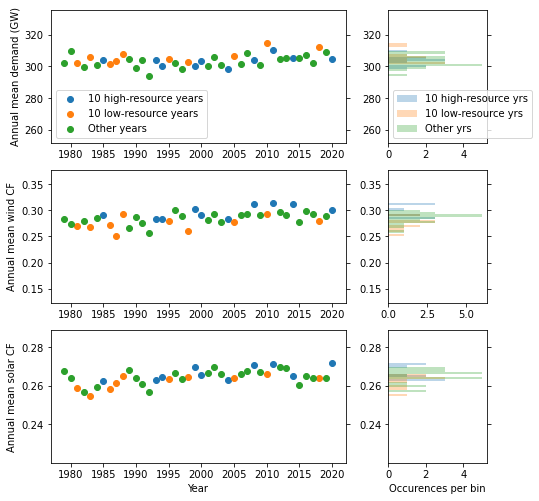

In [4]:
def plot_resources_for_region_PGP(region, df, save_name):

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7.6, 7), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('white')

    i = 0
    for col in df.columns:
        if col == 'year':
            continue
        
        denom = 1 if col != 'demand' else 1000
        for category in ['opt', 'test', 'other']:
            cat = pd.read_csv(f"May31v2_{region}_SWBPGP_max_LL_{category}_years.csv")
            select_years = list(cat['year'])
            tmp = df[ df['year'].isin(select_years) ]
            axs[i][0].scatter(tmp['year'], tmp[col]/denom, marker='o', linestyle='-', label=M[category])
            axs[i][1].hist(tmp[col]/denom, orientation='horizontal', alpha=0.3, label=M[category].replace('years','yrs'))

        
        axs[i][0].set_ylabel(LAB[col][0])
        axs[i][0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
        for NUM in [0, 1]:
            MIN = np.min( df[col]/denom )
            MAX = np.max( df[col]/denom )
            RANGE = MAX - MIN
            
            #axs[i][NUM].set_ylim(LAB[col][1], LAB[col][2])
            axs[i][NUM].set_ylim(MIN - RANGE * 2, MAX + RANGE)
            #axs[i][NUM].set_ylim(0, MAX * 1.2)
            axs[i][NUM].tick_params(right=True)
        i += 1
    axs[-1][0].set_xlabel('Year')
    axs[-1][1].set_xlabel('Occurences per bin')
    axs[0][0].legend(loc='lower left')
    axs[0][1].legend(loc='lower left')


    #loc = 'lower left' if techs != 'SWB' else 'upper left'
    #axs[0].legend(loc=loc, ncol=3)#, bbox_to_anchor=(0.99, 0.8))
        

    
    plt.tight_layout(pad=1)
    plt.savefig(f"plots/{save_name}_PGP_coloring.png")
    print(f"Saving: plots/{save_name}_PGP_coloring.png")
    return


region = 'CONUS'   
plot_resources_for_region_PGP(region, DF, f"si_resources_by_year_{region}")

Saving: plots/si_wind_solar_CONUS_ALL_coloring2.png


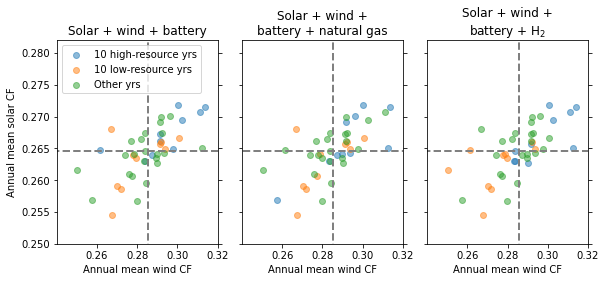

In [5]:
title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\nbattery'+r' + H$_{2}$'
}

def plot_resources_for_region_PGP3(region, df, save_name):

    fig, axs = plt.subplots(ncols=3, figsize=(8.5, 4), sharey=True)
    fig.patch.set_facecolor('white')
    
    x_mean = np.mean(df['wind'])
    y_mean = np.mean(df['solar'])

    for i, techs in enumerate(['SWB', 'SWBNG', 'SWBPGP']):
        axs[i].plot(np.ones(100) * x_mean, np.linspace(0, 1, 100), color='gray', ls='--')
        axs[i].plot(np.linspace(0, 1, 100), np.ones(100) * y_mean, color='gray', ls='--')
        for category in ['opt', 'test', 'other']:
            cat = pd.read_csv(f"May31v2_{region}_{techs}_max_LL_{category}_years.csv")
            select_years = list(cat['year'])
            tmp = df[ df['year'].isin(select_years) ]
            axs[i].scatter(tmp['wind'], tmp['solar'], marker='o', linestyle='-', label=M[category].replace('years','yrs'), alpha=0.5)
        axs[i].set_xlabel(LAB['wind'][0])
        axs[i].set_xlim(.2401, .32)
        axs[i].tick_params(right=True)
        
        axs[i].set_title(title_map[techs])
        

    axs[0].set_ylabel(LAB['solar'][0])  
    axs[0].set_ylim(.25, .282)
    
    axs[0].legend(loc='upper left')

    plt.tight_layout(pad=1)
    plt.savefig(f"plots/{save_name}_ALL_coloring2.png")
    plt.savefig(f"plots/{save_name}_ALL_coloring2.pdf")
    plt.savefig(f"plots/{save_name}_ALL_coloring2.svg")
    print(f"Saving: plots/{save_name}_ALL_coloring2.png")
    return

region = 'CONUS' 
plot_resources_for_region_PGP3(region, DF, f"si_wind_solar_{region}")